# Extract Features

In [1]:
#imports
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [2]:
import re

#load previously saved artifacts
tfidf = joblib.load("../artifacts/punctuation/tfidf_vectorizer.joblib")

#load data (same splits used earlier)
train_csv = "../data/train.csv"

train = pd.read_csv(train_csv)

# preprocess (same method applied earlier)
# cleaning the dataset - lowercases and removes extra whitespaces in every text
def clean_data(text):
    #check for actual missing values
    if pd.isna(text) or text is None:
        return None
        
    #convert to string and strip whitespace
    text_str = str(text).lower().strip()
    
    #check for literal string "None", "nan", or empty
    if text_str in ['none', 'nan', 'null', '']:
        return None
    
    return text_str

train['text_clean'] = train['Text'].apply(clean_data)
train = train.dropna(subset=['text_clean']).reset_index(drop=True)

X_train = tfidf.transform(train['text_clean'])

# Calculate the number of non-zero elements for each row
non_zero_counts = X_train.getnnz(axis=1)

# Identify rows that have at least one valid word
valid_indices = non_zero_counts > 0

# Filter both the Matrix and the DataFrame
X_train = X_train[valid_indices]
train = train[valid_indices].reset_index(drop=True)

print(f"Rows dropped due to empty vectors: {len(valid_indices) - sum(valid_indices)}")
print(f"Final Shape for Clustering: {X_train.shape}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Rows dropped due to empty vectors: 3
Final Shape for Clustering: (50551, 5000)


# a) Apply K-Means with K=5 on your training set.

In [3]:
from sklearn.cluster import KMeans


# Initialize K-Means
kmeans = KMeans(
    n_clusters=5,
    init='k-means++',
    n_init=10,
    random_state=42,
    algorithm = "lloyd",
)

# Fit the model on the training set
print("Fitting K-Means with K=5 on X_train...")
kmeans.fit(X_train)

# Get the cluster assignments
train_cluster_labels = kmeans.labels_

print("K-Means training complete.")
print(f"Cluster labels shape: {train_cluster_labels.shape}")

# Save the model for use in 3b and 3c
joblib.dump(kmeans, "../artifacts/punctuation/models/kmeans_model.joblib")

Fitting K-Means with K=5 on X_train...
K-Means training complete.
Cluster labels shape: (50551,)


['../artifacts/punctuation/models/kmeans_model.joblib']

# b) Inspect 3 documents closest to each centroid, and afterwards, assign semantic labels to each cluster (e.g., “political fake news”, “health misinformation”).

In [4]:
dist_matrix = kmeans.transform(X_train)

# Iterate through each cluster to find nearest docs and top terms
print("--- Cluster Inspection ---")

feature_names = np.array(tfidf.get_feature_names_out())

for cluster_id in range(5):
    print(f"\n### CLUSTER {cluster_id} ###")
    
    # A. Print Top Keywords (Crucial for labeling!)
    # We find the center of the cluster and get the indices of the highest values
    centroid = kmeans.cluster_centers_[cluster_id]
    # Sort indices by value descending
    top_term_indices = centroid.argsort()[::-1][:10] 
    top_terms = feature_names[top_term_indices]
    print(f"Key Terms: {', '.join(top_terms)}")
    
    print("-" * 40)
    
    # B. Print Closest Documents
    closest_doc_indices = dist_matrix[:, cluster_id].argsort()[:3]

    for idx in closest_doc_indices:
        original_text = train.iloc[idx]['Text']
        label = train.iloc[idx]['Label']
        
        # Print a snippet (first 300 chars) to keep output readable
        print(f"  - [Row {idx}] (Label: {label}): {original_text[:300]}...")

--- Cluster Inspection ---

### CLUSTER 0 ###
Key Terms: do, da, em, para, no, os, com, um, na, se
----------------------------------------
  - [Row 11705] (Label: 0): Ministra da Justiça cria lei contra a corrupção, que deixa os mais corruptos de fora? Ministra da Justiça preparou diploma para advogados que prevê que eleitos para cargos relacionados com o poder local não possam exercer aquela profissão. Deputados da Assembleia da República estão fora desta proibi...
  - [Row 23059] (Label: 0): José Eduardo dos Santos, o déspota discreto Chegou ao poder porque era, dos presidenciáveis, o mais fraco. Nos primeiros anos, não “mexeu uma palha”. Mas demonstrou a capacidade de adaptação suficiente para sobreviver à queda do Muro de Berlim, abraçar o capitalismo mais selvagem e ainda enriquecer-...
  - [Row 33721] (Label: 0): José Eduardo dos Santos, o déspota discreto Chegou ao poder porque era, dos presidenciáveis, o mais fraco. Nos primeiros anos, não “mexeu uma palha”. Mas demonstrou a c

# c) Visualize clusters in 2D using PCA. Create two plots: one colored by cluster assignment, one by true label.

Starting dimensionality reduction...
Reduction complete. New shape: (50551, 2)


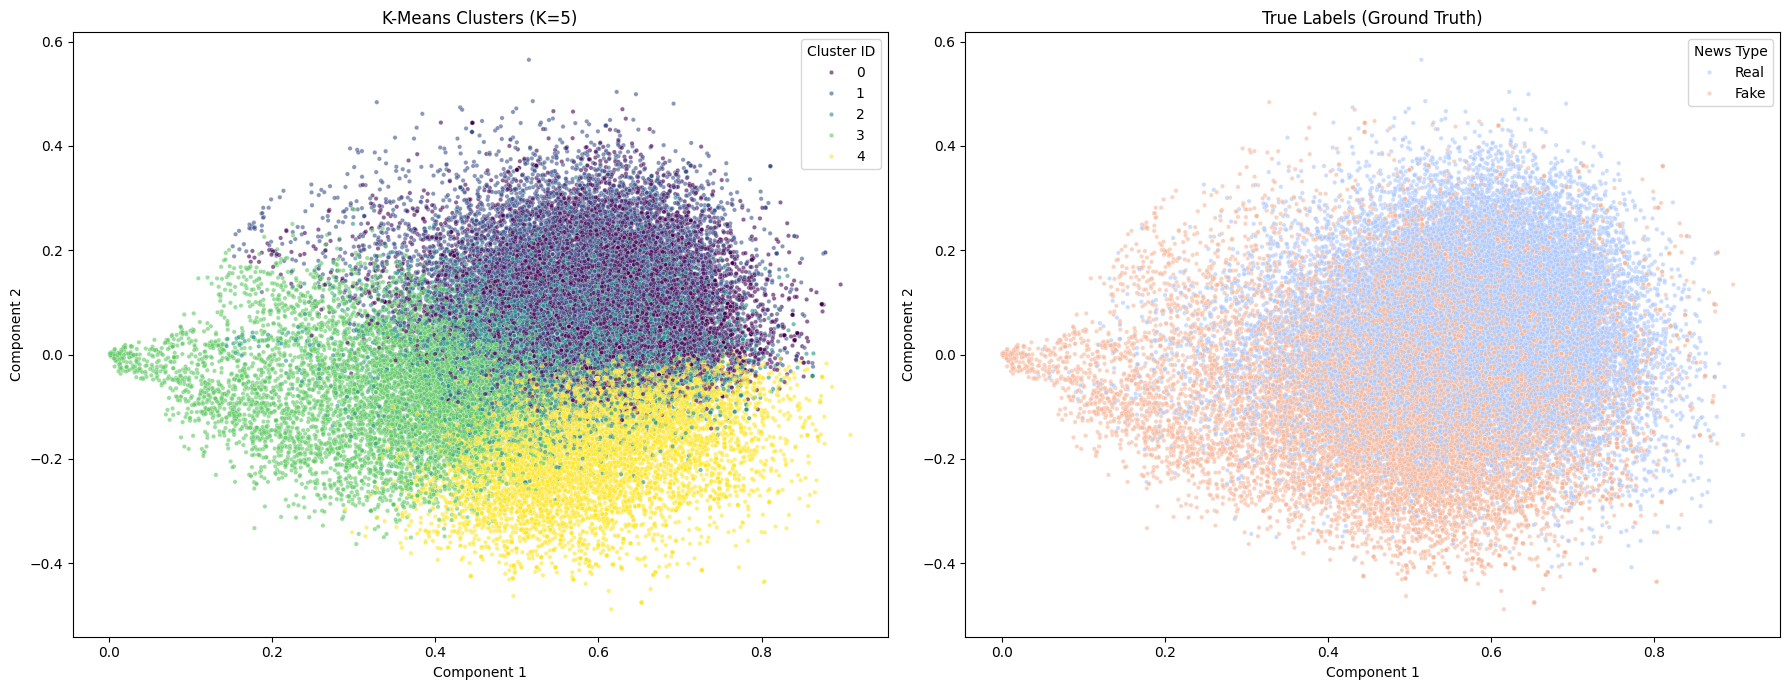

In [5]:
# --- 3c) Visualize clusters in 2D using PCA ---

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting dimensionality reduction...")

# 1. Reduce dimensions to 2D
# Note: We use TruncatedSVD because standard PCA does not support sparse inputs 
# without converting to dense (which crashes memory on large text datasets).
pca_reducer = TruncatedSVD(n_components=2, random_state=42)
X_2d = pca_reducer.fit_transform(X_train)

print(f"Reduction complete. New shape: {X_2d.shape}")

# 2. Prepare Data for Plotting
# We create a temporary DataFrame to make plotting with Seaborn easier
plot_df = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])
plot_df['Cluster'] = train_cluster_labels
# Map labels for better legend readability (0=Fake, 1=Real)
plot_df['True Label'] = train['Label'].map({0: 'Fake', 1: 'Real'})

# 3. Create the Side-by-Side Plots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Colored by Cluster Assignment ---
sns.scatterplot(
    data=plot_df, 
    x='Component 1', 
    y='Component 2', 
    hue='Cluster', 
    palette='viridis', 
    s=10,             # Marker size
    alpha=0.6,        # Transparency
    ax=axes[0]
)
axes[0].set_title('K-Means Clusters (K=5)')
axes[0].legend(title='Cluster ID')

# --- Plot 2: Colored by True Label ---
sns.scatterplot(
    data=plot_df, 
    x='Component 1', 
    y='Component 2', 
    hue='True Label', 
    palette='coolwarm', # Red for Fake (warm), Blue for Real (cool) usually
    s=10, 
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_title('True Labels (Ground Truth)')
axes[1].legend(title='News Type')

plt.tight_layout()
plt.show()